In [4]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from keras.utils import plot_model
from tensorflow.keras import optimizers

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [18]:
DATA_DIR = 'FaceShape Dataset'

In [28]:
TRAIN_DIR = os.path.join(DATA_DIR, 'training_set')
TEST_DIR = os.path.join(DATA_DIR, 'testing_set')

In [29]:
def num_of_classes(folder_dir, folder_name):
    classes = [class_name for class_name in os.listdir(TRAIN_DIR)]
    print(f'number of classes in {folder_name} folder : {len(classes)}')

In [30]:
num_of_classes(TRAIN_DIR, 'train')
# num_of_classes(VAL_DIR, 'validation')
num_of_classes(TEST_DIR, 'test')

number of classes in train folder : 5
number of classes in test folder : 5


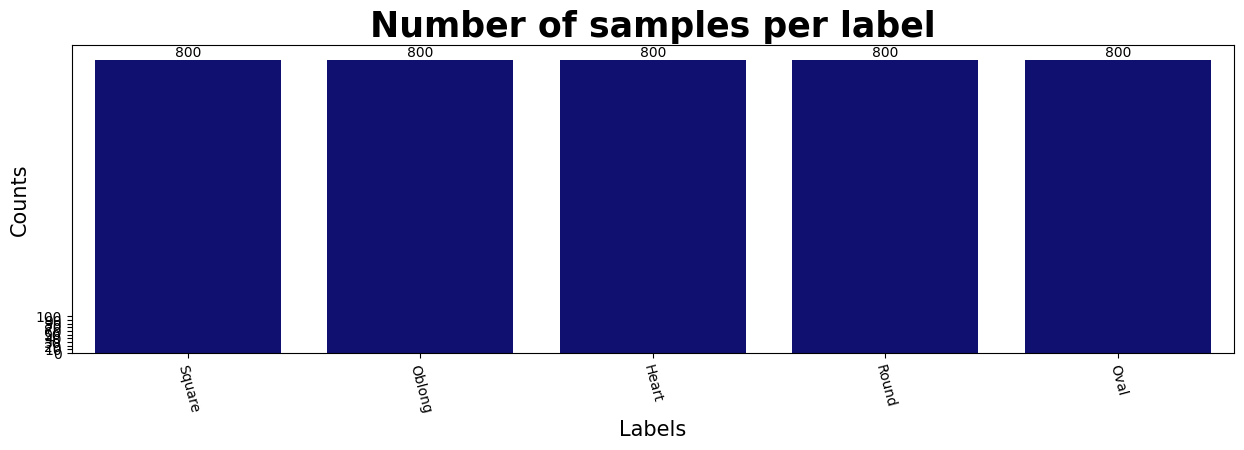

In [31]:
classes = [class_name for class_name in os.listdir(TRAIN_DIR)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(TRAIN_DIR, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

In [32]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [33]:
train_df = create_df(TRAIN_DIR)
# validation_df = create_df(VAL_DIR)
test_df = create_df(TEST_DIR)

In [34]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
# print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 4000
Number of samples test : 1001


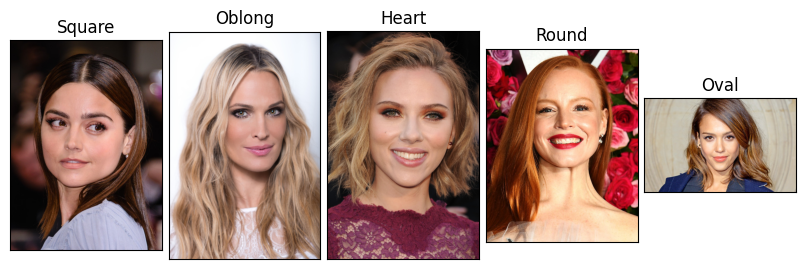

In [35]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [36]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 4000 validated image filenames belonging to 5 classes.


In [37]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 1000 validated image filenames belonging to 5 classes.


/home/kaleab/Desktop/AI projects/AI-hairstyle-app/backend/venv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


In [58]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

In [59]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

In [60]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [61]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [62]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [63]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,461 (9.99 MB)

 Trainable params: 1,247,557 (4.76 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

In [64]:
# Compile
model.compile(optimizer=optimizers.Nadam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [65]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=30, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [66]:
from PIL import ImageFile

# Set Pillow to load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    epochs=100,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 559ms/step - accuracy: 0.3288 - loss: 1.5290 - val_accuracy: 0.3720 - val_loss: 2.6932 - learning_rate: 0.0010
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 550ms/step - accuracy: 0.4891 - loss: 1.2633 - val_accuracy: 0.3990 - val_loss: 2.5362 - learning_rate: 0.0010
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 536ms/step - accuracy: 0.5334 - loss: 1.1572 - val_accuracy: 0.3060 - val_loss: 3.6636 - learning_rate: 0.0010
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 547ms/step - accuracy: 0.5723 - loss: 1.0803 - val_accuracy: 0.4530 - val_loss: 2.1330 - learning_rate: 0.0010
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 530ms/step - accuracy: 0.6007 - loss: 0.9984 - val_accuracy: 0.4000 - val_loss: 2.2651 - learning_rate: 0.0010
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 535ms/step - accuracy: 0.6143 - loss: 0.9844 - val_accuracy: 0.3550 - val_loss: 3.3453 - learning_rate: 0.0010
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 550ms/step - accura

In [67]:
model.save('face_shape_model.h5')

In [69]:
model.save('MyModel.keras')

In [70]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
32,0.92725,0.209614,0.578,2.067074,0.00025
33,0.92025,0.211378,0.584,1.996832,0.00025
34,0.92675,0.197833,0.550,2.278256,0.00025
35,0.92350,0.208241,0.554,2.414892,0.00025
36,0.92900,0.192066,0.552,2.100383,0.00025


In [71]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = models.load_model('MyModel.keras')

/home/kaleab/Desktop/AI projects/AI-hairstyle-app/backend/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 39 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [72]:
test_loss, test_acc = best_model.evaluate(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.4635 - loss: 1.9330
Test Loss : 1.918
Test Accuracy : 0.447


In [ ]:
# Atau dalam format HDF5
model.save('/kaggle/working/MyModel.keras')

In [ ]:
import os

# Cek apakah file sudah tersimpan
print(os.listdir('/kaggle/working/'))

AttributeError: 'DataFrame' object has no attribute 'lr'

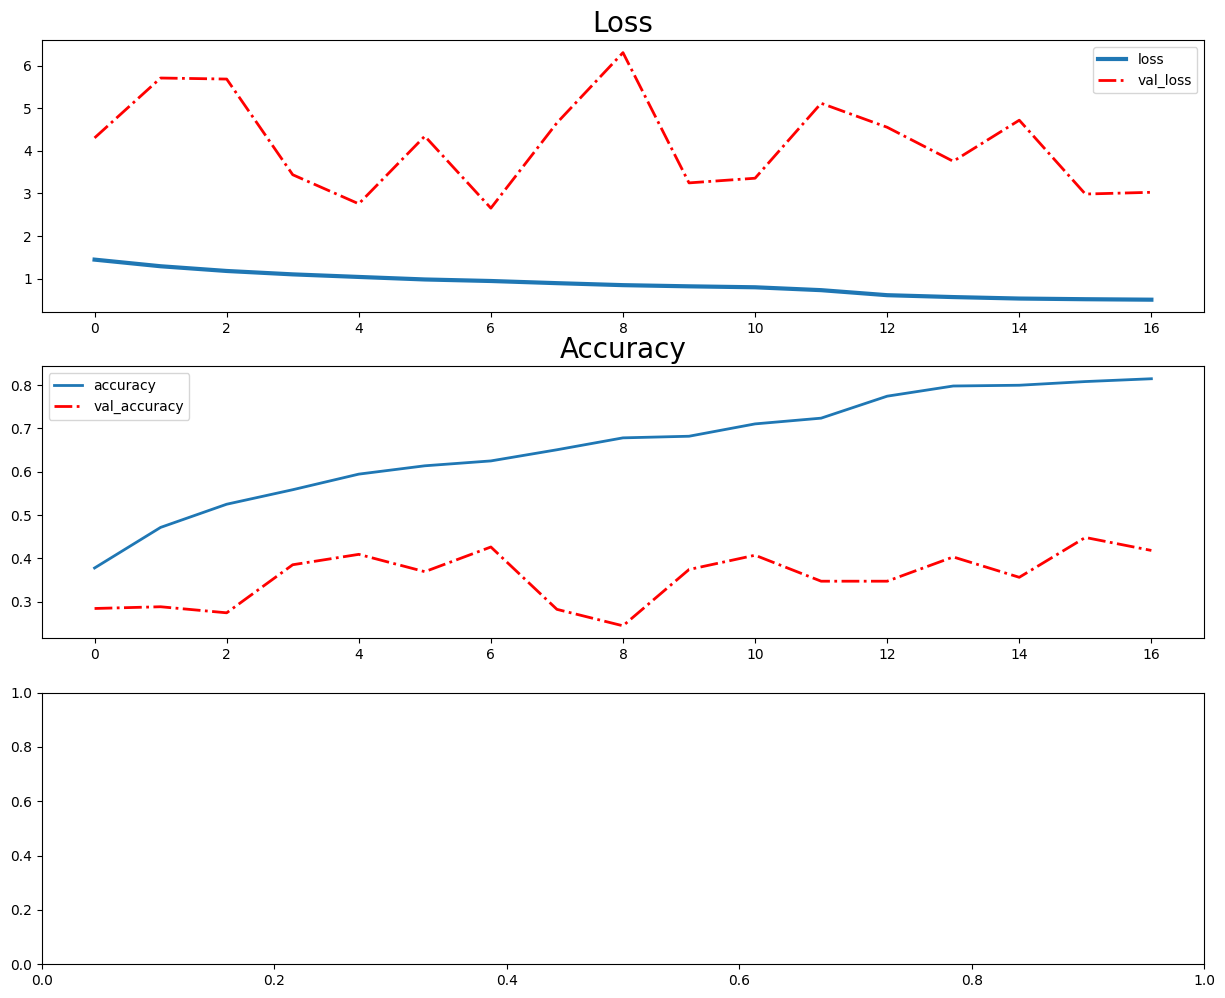

In [51]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

In [73]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step
              precision    recall  f1-score   support

       Heart       0.35      0.76      0.48       200
      Oblong       0.50      0.51      0.50       200
        Oval       0.38      0.23      0.29       200
       Round       0.68      0.34      0.46       200
      Square       0.56      0.39      0.46       200

    accuracy                           0.45      1000
   macro avg       0.49      0.45      0.44      1000
weighted avg       0.49      0.45      0.44      1000





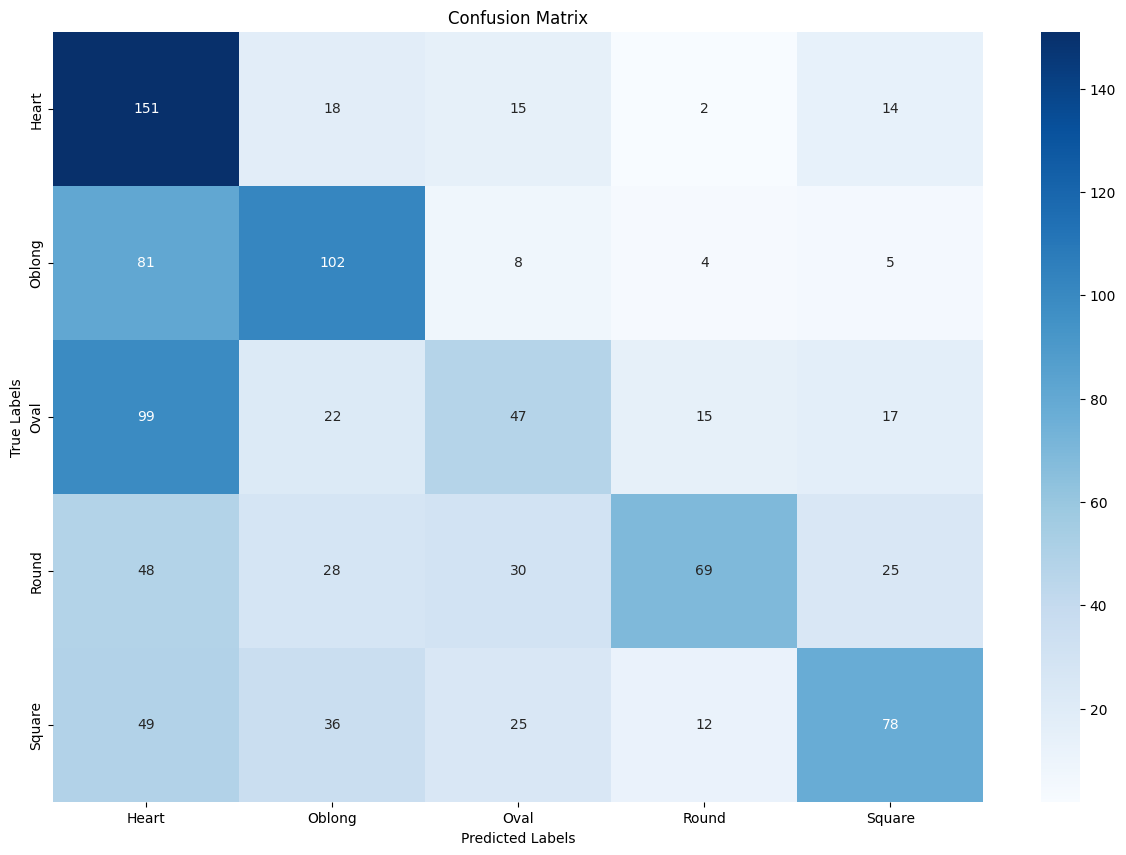

In [74]:
evaluate_model_performance(best_model, test_generator, classes)
